# Monte Carlo methods
Auhtor: Artur Kalinowski

To pen the slides please use this [link](https://akalinow.github.io/Modern_Particle_Physics_Experiments/slides/monte_carlo_01.pdf)

In [1]:
from IPython.display import IFrame
#This might not work in colab. I such a case follow the link to the slides above. 
IFrame("https://akalinow.github.io/Modern_Particle_Physics_Experiments/slides/monte_carlo_01.pdf", width=1000, height=700)

## Setup the environment

In [2]:
#import ROOT

#Color printing
from termcolor import colored

#General data operations library
import math
import numpy as np

#HEP specific tools
import scipy.constants as scipy_constants

#Plotting libraries
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

Generate 10k numbers from range [0,1] according to triangle distribution:
\begin{equation}
 p(x) = \frac{1}{2}x \cdot sgn(x-0.5)
\end{equation}


* use the inverse of the cumulative distribution

In [3]:
def pdf(x):
    p = 0
    if x>0 and x<1: 
        p = 0.5*x*np.sign(x-0.5)
    return p

pdf(0.5)

0.0

### Print out the values and uncerainties of:

* the Fermi constant
* muon mass
* electron mass
* define variables ```G_F```, ```m_e``` and ```m_mu``` containg only the values of relevant contants

In [4]:
G_F = scipy_constants.physical_constants["Fermi coupling constant"]
m_e = scipy_constants.physical_constants["electron mass energy equivalent in MeV"]
m_mu = scipy_constants.physical_constants["muon mass energy equivalent in MeV"]

print("Fermi constant: {} +- {} {}".format(G_F[0], G_F[2], G_F[1]))
print("muon mass: \t{} +- {} {}".format(m_mu[0], m_mu[2], m_mu[1]))
print("electron mass: \t{} +- {} {}".format(m_e[0], m_e[2], m_e[1]))

G_F = G_F[0]
m_e = m_e[0]
m_mu = m_mu[0]

Fermi constant: 1.1663787e-05 +- 6e-12 GeV^-2
muon mass: 	105.6583755 +- 2.3e-06 MeV
electron mass: 	0.51099895 +- 1.5e-10 MeV


* write a function coding the differential decay width: ```dGamma_dE(E)```
* calculate the value of the total decay width: ```Gamma_tot```

In [5]:
def dGamma_dE(e):
    value = G_F**2/(4.0*math.pi**3)
    value *= m_mu**2*e**2*(1 - 4.0/3.0*e/m_mu)
    return value

Gamma_tot = G_F**2*m_mu**5/(192.0*math.pi**3)


* what is the maximum electron energy ```e_max``` in muon decay (neglecting the neutrinos mass)?

In [6]:
e_max = (m_mu**2 - m_e**2)/(2.0*m_mu)
print("Maximum electron energy in muon decay (neglecting neutrinos mass): {} MeV".format(e_max))

Maximum electron energy in muon decay (neglecting neutrinos mass): 52.827952069791664 MeV


### Plot the probability for the electron energy

* check that the normalisation is correct - calculate numerically
\begin{equation}
\int p(E) dE
\end{equation}


Integral of p(E) is: 0.9999534560386484


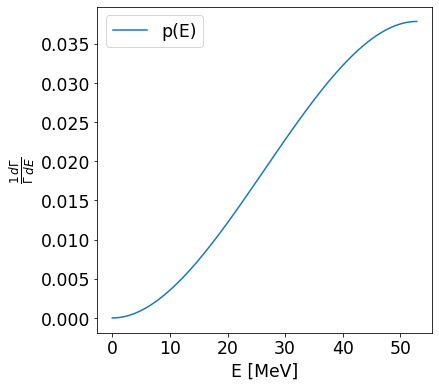

In [7]:
nPoints = 100
e = np.linspace(0.0, e_max, nPoints)
p = dGamma_dE(e)/Gamma_tot

print("Integral of p(E) is:",np.sum(p)*e_max/nPoints)

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(e,p, label="p(E)");
ax.set_xlabel("E [MeV]")
ax.set_ylabel(r"$\frac{1}{\Gamma} \frac{d\Gamma}{dE}$")
ax.legend();

### Generate "events" with energy distribution according to $\mu \rightarrow e \nu$ decay

* use "hit-or-miss method":
    1) generate energy ```e``` from flat spectrum [0, $E_{max}$]
    2) generate random number ```x``` from flat spectrum [0,1]
    3) accept event if ```x<p(e)```
    4) what is efficiency (=what fraction of events is kept) of this method?
    5) How long it takes to generate 100k usefull events?
 
--- 
**Hint:**  try to use numpy array operations instead of loops. This will be much faster.  

In [8]:
%%time

nEvents = int(2E6)
events = e_max*np.random.random_sample(nEvents)
x = np.random.random_sample(nEvents)
p = dGamma_dE(events)
p = p/np.max(p)
accept = x<p

events = events[accept]
print("Number of accepted events:\t",events.shape[0])
print("Accepted events fraction:\t",events.shape[0]/nEvents)

Number of accepted events:	 999564
Accepted events fraction:	 0.499782
CPU times: user 55 ms, sys: 152 µs, total: 55.1 ms
Wall time: 54.3 ms


### Draw a histogram of the energy with p(E) overlaid

Integral of p(E) is: 0.9999532221306278


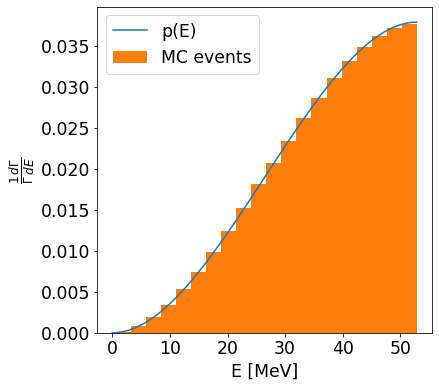

In [9]:
nPoints = 10000
e = np.linspace(0.0, e_max, nPoints)
p = dGamma_dE(e)/Gamma_tot

print("Integral of p(E) is:",np.sum(p)*e_max/nPoints)

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(e,p, label="p(E)");
ax.hist(events,bins=20, density=True, label = "MC events")
ax.set_xlabel("E [MeV]")
ax.set_ylabel(r"$\frac{1}{\Gamma} \frac{d\Gamma}{dE}$")
ax.legend();

### Define function ```efficiency(pt, eta)``` representing some detector efficiency. 

The efficiency plateau $\epsilon_0$, and turn on $p_{T0}$ point should depend on $\eta$:

\begin{equation}
\epsilon_{0} = 0.95 - |\eta| \cdot 0.1 \\
 p_{T0} = 30 + 20 \cdot cos(\eta)
\end{equation}

Use the sigmoid function for the efficiency shape. The pT should be in range [0,100], an $\eta$ in [-2.5, 2.5].

In [10]:
def efficiency(pt, eta):
    pt0 = 30+20*np.cos(eta)
    x = pt-pt0
    epsilon0 = 0.95 - np.abs(eta)*0.1
    return epsilon0/(1 + np.exp(-x))

### Make 1D and 2D plots:

* 1D plot for $\epsilon(p_{T}, \eta={-2, 0, 1})$
* 2D plot for the full map $\epsilon(p_{T}, \eta)$

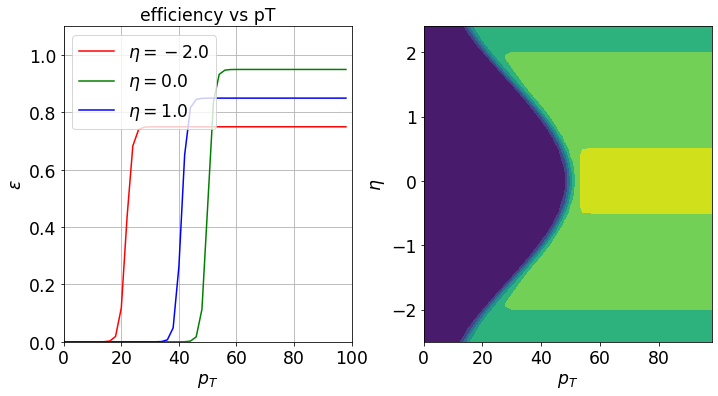

In [11]:
pt = np.arange(0,100,2.0)
eta = np.arange(-2.5, 2.5, 0.1)
pt_grid, eta_grid = np.meshgrid(pt, eta)

fig, axes = plt.subplots(1, 2, figsize = (10, 6))  
axes[0].plot(pt, efficiency(pt, -2.0), "r", label = r'$\eta = -2.0$')
axes[0].plot(pt, efficiency(pt, 0.0), "g",label = r'$\eta = 0.0$')
axes[0].plot(pt, efficiency(pt, 1.0), "b",label = r'$\eta = 1.0$')

maxY = 1.1
maxX = 100
axes[0].set_ylabel(r'$\epsilon$');
axes[0].set_xlabel(r'$p_{T}$');
axes[0].grid()
axes[0].set_ylim([0,maxY])
axes[0].set_xlim([0,maxX])
axes[0].set_title("efficiency vs pT")
axes[0].legend(loc='upper left')

axes[1].contourf(pt_grid, eta_grid, efficiency(pt_grid, eta_grid))
axes[1].set_ylabel(r'$\eta$');
axes[1].set_xlabel(r'$p_{T}$');

plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.25, hspace=0.35)

### Write a function ```generateData(nPoints, efficiency)``` that generates a sample of ```nPoints``` events, with information wheter an event was accepted, according to function ```effciency(pT, eta)``` that parametrises $\epsilon$ 

* assume flat $p_{T}$ and $\eta$ spectrum. The pT should be in range [0,100], an $\eta$ in [-2.5, 2.5].
* to each $(p_{T}, \eta)$ pair assing a third variable: ```label``` randomly set to 0 or 1 according to the  ```efficiency(pt, eta)```
* select evvents that "passed the selection" : ```label>0```
* draw a efficiency histogram calculated from the sample, overlaid with efficiency curve for $|\eta|<0.1$

In [12]:
def generateData(nPoints, efficiency):
    scale = [100, 2*2.1]
    offset = [0, -2.1]

    features = np.random.random_sample(size=(nPoints,2))
    features = features*scale + offset
        
    flatRndm = np.random.random_sample(size=(nPoints,))
    labels = flatRndm<efficiency(features[:,0], features[:,1])
    labels = np.reshape(labels, (-1,1))
    return np.concatenate((features,labels), axis=1)

* generate 100k events
* select data rows with $|\eta|<0.1$
* further select accepted events with ```pass>0```
* calculate efficiency a ratio of accepted to total events in bint of $p_{T}$. Use 10 bins. 

**Hints:** 
* for counting numbeszs of events in bins use ```np.hist```
* for getting the bin centers use ```np.diff```

In [13]:
%%time
nPoints = 100000
binWidth = 1.0
data = generateData(nPoints, efficiency)
data_eta01 = data[np.abs(data[:,1])<0.05]
data_pass = data_eta01[data_eta01[:,2]>0]

pass_histo, bins = np.histogram(data_pass[:,0], bins=np.arange(0,100,binWidth))
all_histo, bins =  np.histogram(data_eta01[:,0], bins=np.arange(0,100,binWidth))
ratio = np.divide(pass_histo, all_histo.astype(float))
binCenters = bins[:-1] + np.diff(bins)

CPU times: user 7.01 ms, sys: 0 ns, total: 7.01 ms
Wall time: 6.64 ms


* plot efficiency from function for $\eta=0$
* overlay efficiency from event counting from data
* do the two agree? If not exactly, then why?

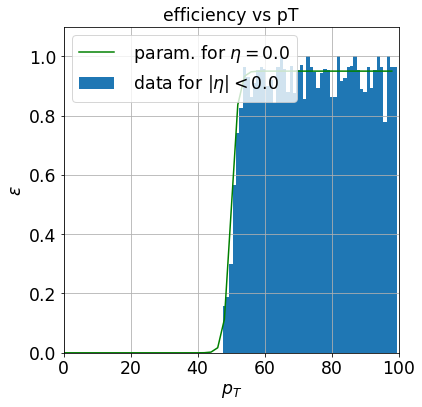

In [14]:
pt = np.arange(0,100,2.0)
eta = np.arange(-2.5, 2.5, 0.1)
pt_grid, eta_grid = np.meshgrid(pt, eta)

fig, ax = plt.subplots(figsize = (6, 6))  
ax.plot(pt, efficiency(pt, 0.0), "g",label = r' param. for $\eta = 0.0$')
ax.bar(binCenters, ratio, width=binWidth,label = r' data for |$\eta|<0.0$')

maxY = 1.1
maxX = 100
ax.set_ylabel(r'$\epsilon$');
ax.set_xlabel(r'$p_{T}$');
ax.grid()
ax.set_ylim([0,maxY])
ax.set_xlim([0,maxX])
ax.set_title("efficiency vs pT")
ax.legend(loc='upper left');